<a href="https://colab.research.google.com/github/Kalisa21/FastAPI/blob/main/bot_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

T5-small

BERT UNCASED

In [1]:
!pip install -q transformers datasets evaluate nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00


In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import T5Tokenizer, TFT5ForConditionalGeneration, create_optimizer
import tensorflow as tf
import evaluate
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
dataset = load_dataset("Nagasai0511/llama3_medquad_instruct_dataset")
df = pd.DataFrame(dataset["train"])
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/389 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16359 [00:00<?, ? examples/s]

,input,output,instruction,prompt
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,"Answer the question truthfully, you are a medi...",<|start_header_id|>system<|end_header_id|> Ans...
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...","Answer the question truthfully, you are a medi...",<|start_header_id|>system<|end_header_id|> Ans...
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,"Answer the question truthfully, you are a medi...",<|start_header_id|>system<|end_header_id|> Ans...
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...","Answer the question truthfully, you are a medi...",<|start_header_id|>system<|end_header_id|> Ans...
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,"Answer the question truthfully, you are a medi...",<|start_header_id|>system<|end_header_id|> Ans...


Dataset Shape: (16359, 4)

Missing Values:
 input          0
output         0
instruction    0
prompt         0
dtype: int64


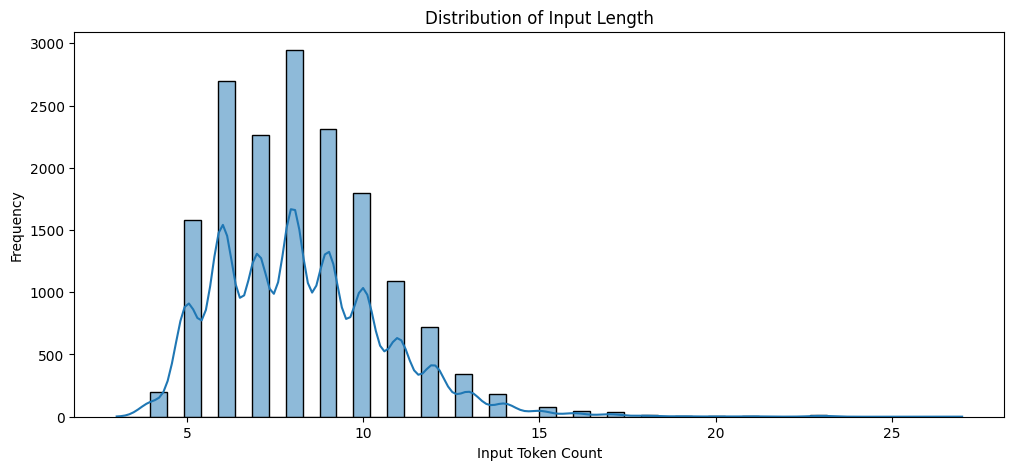

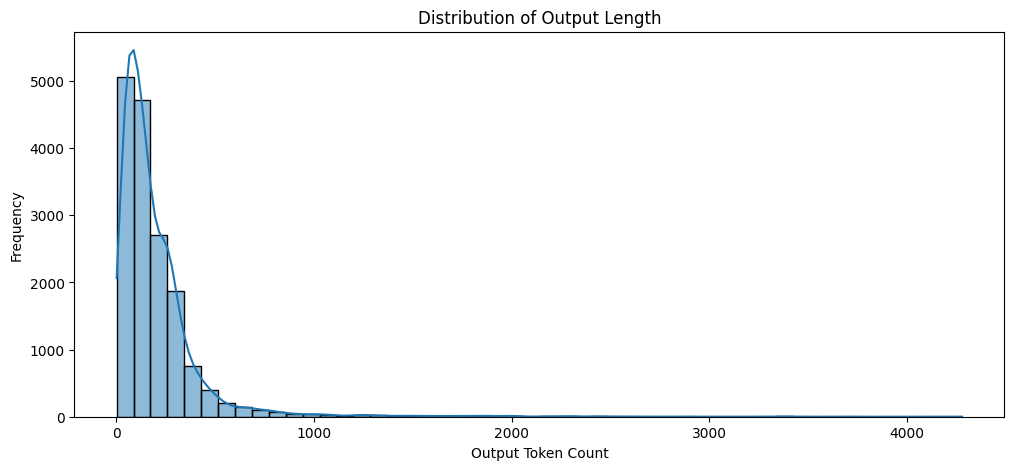

In [5]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

# Length Analysis
df['length_input'] = df['input'].apply(lambda x: len(str(x).split()))
df['length_output'] = df['output'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(df['length_input'], bins=50, kde=True)
plt.title("Distribution of Input Length")
plt.xlabel("Input Token Count")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['length_output'], bins=50, kde=True)
plt.title("Distribution of Output Length")
plt.xlabel("Output Token Count")
plt.ylabel("Frequency")
plt.show()


In [6]:
from transformers import T5Tokenizer

# Load the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
def preprocess(batch):
    input_texts = [instr + " " + inp for instr, inp in zip(batch["instruction"], batch["input"])]
    target_texts = batch["output"]

    model_inputs = tokenizer(input_texts, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target_texts, max_length=128, truncation=True, padding="max_length").input_ids

    model_inputs["labels"] = labels
    return model_inputs

tokenized_datasets = dataset.map(preprocess, batched=True)


Map:   0%|          | 0/16359 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [8]:
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

batch_size = 8
epochs = 3
num_train_steps = len(tokenized_datasets["train"]) // batch_size * epochs

optimizer, schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=0, num_train_steps=num_train_steps)
model.compile(optimizer=optimizer)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [9]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=batch_size
)

history = model.fit(tf_train_dataset, epochs=epochs)


Epoch 1/3
2045/2045 [==============================] - 845s 388ms/step - loss: 2.6292
Epoch 2/3
2045/2045 [==============================] - 792s 387ms/step - loss: 2.2467
Epoch 3/3
2045/2045 [==============================] - 791s 387ms/step - loss: 2.1808


In [10]:
def chat_with_bot(query):
    input_text = "healthcare: " + query
    inputs = tokenizer(input_text, return_tensors="tf", padding=True, truncation=True)
    output = model.generate(**inputs, max_new_tokens=100)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test
print(chat_with_bot("What are the symptoms of hypertension?"))


In [19]:
def chat_with_bot(query):
    input_text = "Give short medical advice: " + query
    inputs = tokenizer(input_text, return_tensors="tf", padding=True, truncation=True)
    output = model.generate(**inputs, max_new_tokens=100)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test again
print(chat_with_bot("What are the symptoms of hypertension?"))


In [20]:
print(chat_with_bot("What is the treatment for asthma?"))

In [21]:
def is_healthcare_related(query):
    keywords = ["symptom", "treatment", "disease", "doctor", "medicine", "health", "pain", "diagnosis", "therapy"]
    return any(word in query.lower() for word in keywords)

def safe_chatbot(query):
    if is_healthcare_related(query):
        return chat_with_bot(query)
    else:
        return "I'm designed to answer healthcare-related questions. Please ask something related to health."

# Examples
print(safe_chatbot("Tell me a joke"))
print(safe_chatbot("What is asthma?"))


I'm designed to answer healthcare-related questions. Please ask something related to health.
I'm designed to answer healthcare-related questions. Please ask something related to health.


In [ ]:
model.save_pretrained("/content/healthcare_t5_model")
tokenizer.save_pretrained("/content/healthcare_t5_model")


('/content/healthcare_t5_model/tokenizer_config.json',
 '/content/healthcare_t5_model/special_tokens_map.json',
 '/content/healthcare_t5_model/spiece.model',
 '/content/healthcare_t5_model/added_tokens.json')

In [12]:
!pip install gradio

In [13]:
import gradio as gr

# Chat function for Gradio
def chatbot_response(user_query):
    # Optional: reject out-of-domain queries
    keywords = ["symptom", "treatment", "disease", "doctor", "medicine", "health", "pain", "diagnosis", "therapy"]
    if not any(word in user_query.lower() for word in keywords):
        return "I'm designed to answer healthcare-related questions. Please ask something related to health."

    input_text = "healthcare: " + user_query
    inputs = tokenizer(input_text, return_tensors="tf", padding=True, truncation=True)
    output = model.generate(**inputs, max_new_tokens=100)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response


In [14]:
iface = gr.Interface(
    fn=chatbot_response,
    inputs=gr.Textbox(lines=2, placeholder="Ask a healthcare-related question..."),
    outputs="text",
    title="Healthcare Chatbot",
    description="Ask questions related to symptoms, treatments, diseases, and general health advice."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a40b8e366a2a435707.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
